In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier



from datetime import datetime
import datetime
import calendar
import time
from functools import reduce

from sklearn.model_selection import train_test_split


import MySQLdb
import pandas as pd
import xlrd
from datetime import datetime

/home/js/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:

# 資料說明
# 本議題所提供之資料為內湖區矩型地理範圍內之計程車載客時間、地點GPS資料。資料涵蓋時間為2016-02-01 08:00:00~2017-01-31 23:59:59，共計4,118,812筆。

# 載客熱點預測方式為：將內湖區矩型地理範圍切分為25個地理區塊，預測特定區塊於一段時間（一個月）中，各時段的乘車需求。

# 下載資料taxi_data.zip檔案包含：


# zones.csv：內湖區5x5網格區塊編號及邊界定義，(WGS84座標)。
# Zone_ID：區塊編號
# Left：區塊左邊界
# Top：區塊上邊界
# Right：區塊右邊界
# Bottom：區塊下邊界


# zones.png：內湖區5x5網格區塊地圖


# train_gps_points.csv：乘客上車GPS點位記錄，此資料乃經由篩選計程車錶於內湖區矩型地理範圍內的啟動記錄而得，並且將計程車錶啟動時間與地點視為乘客上車點，共4,118,812筆資料。
# Datetime：計程車錶啟動時間 (台北時間 GMT+8:00)
# Longitude_X：GPS記錄經度 (WGS84座標)
# Latitude_Y：GPS記錄緯度 (WGS84座標)
# Zone_ID：區塊編號


# train_hire_stats.csv：內湖區各網格區塊之載客統計資料。
# Zone_ID：區塊編號
# Date：統計日期，格式 YYYY-mm-dd，如2016-02-01
# Hour_slot：統計時段，以一小時計，本欄位的值為0~23。
# 0代表0:00:00~0:59:59時段，1代表1:00:00~1:59:59，依此類推，23代表23:00:00~23:59:59
# Hire_count：該區塊、該時段的總載客量


# test_hire_stats.csv：乘車需求預測。
# Test_ID：乘車需求之區塊、時間組合流水序號，共6,048筆
# Zone_ID：區塊編號，包含：7、8、9、12、13、14、17、18、19共九個區塊
# Date：預測日期，格式 YYYY-mm-dd，如2017-02-01
# Hour_slot：預測時段，以一小時計，本欄位的值為0~23。
# 0代表0:00:00~0:59:59時段，1代表1:00:00~1:59:59，依此類推，23代表23:00:00~23:59:59
# Hire_count：該區塊、該時段的乘車需求預測數量，本欄位下載時為空值，請您填入您的預測值 (正整數值，0~n) 後上傳


Linear regression analysis with string/categorical features (variables)?


Yes, you will have to convert everything to numbers. That requires thinking about what these attributes represent.

Usually there are three possibilities:

1. One-Hot encoding for categorical data
2. Arbitrary numbers for ordinal data
3. Use something like group means for categorical data (e. g. mean prices for city districts).

You have to be carefull to not infuse information you do not have in the application case.




In [10]:
#train_gps_points_url = "C:/Users/JS/py_ds/taxi_data/taxi_data/train_gps_points.csv"
#train_hire_stats_url = "C:/Users/JS/py_ds/taxi_data/taxi_data/train_hire_stats.csv"
#zones_url = "C:/Users/JS/py_ds/taxi_data/taxi_data/zones.csv"

#test_hire_stats_url = "C:/Users/JS/py_ds/taxi_data/taxi_data/test_hire_stats.csv"

train_gps_points_url = "/home/js/py_ds_nas/taxi_data/data/train_gps_points.csv"
train_hire_stats_url = "/home/js/py_ds_nas/taxi_data/data/train_hire_stats.csv"
zones_url = "/home/js/py_ds_nas/taxi_data/data/zones.csv"

test_hire_stats_url = "/home/js/py_ds_nas/taxi_data/data/test_hire_stats.csv"




train_gps_points = pd.read_csv(train_gps_points_url)
train_hire_stats = pd.read_csv(train_hire_stats_url)
zones = pd.read_csv(zones_url)

test_hire_stats = pd.read_csv(test_hire_stats_url)

In [4]:
print("-----------------train_gps_points : %s" % train_gps_points.info())
print("\n-- \n")
print("-----------------train_hire_stats : %s" % train_hire_stats.info())
print("\n-- \n")
print("-----------------zones : %s" % zones.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4118812 entries, 0 to 4118811
Data columns (total 4 columns):
Datetime       object
Longitude_X    float64
Latitude_Y     float64
Zone_ID        int64
dtypes: float64(2), int64(1), object(1)
memory usage: 125.7+ MB
-----------------train_gps_points : None

-- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219600 entries, 0 to 219599
Data columns (total 4 columns):
Zone_ID       219600 non-null int64
Date          219600 non-null object
Hour_slot     219600 non-null int64
Hire_count    219600 non-null int64
dtypes: int64(3), object(1)
memory usage: 6.7+ MB
-----------------train_hire_stats : None

-- 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 5 columns):
Zone_ID    25 non-null int64
left       25 non-null float64
top        25 non-null float64
right      25 non-null float64
bottom     25 non-null float64
dtypes: float64(4), int64(1)
memory usage: 1.1 KB
-----------------zones : None


In [36]:

conn = MySQLdb.connect(host="127.0.0.1",    # your host, usually localhost
                     user="root",         # your username
                     passwd="",           # your password
                     db = "for_taxi",    # name of the data base         
                     use_unicode=True, 
                     charset="utf8")

train_hire_stats = pd.read_sql('SELECT * FROM train_hire_stats__test', con=conn)

train_hire_stats

,Zone_ID,Date,Week_day,Hour_slot,Hire_count,Ubike_num,is_weekend
0,1,2016-02-01,1,0,0,None,0
1,1,2016-02-01,1,1,0,None,0
2,1,2016-02-01,1,2,0,None,0
3,1,2016-02-01,1,3,0,None,0
4,1,2016-02-01,1,4,0,None,0
5,1,2016-02-01,1,5,0,None,0
6,1,2016-02-01,1,6,0,None,0
7,1,2016-02-01,1,7,0,None,0
8,1,2016-02-01,1,8,0,None,0
9,1,2016-02-01,1,9,0,None,0


In [50]:
# train_hire_stats["Date"] = train_hire_stats["Date"].astype('datetime64[ns]')
train_hire_stats["Date"] = pd.to_datetime(train_hire_stats["Date"])

In [51]:
train_hire_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219600 entries, 0 to 219599
Data columns (total 7 columns):
Zone_ID       219600 non-null int64
Date          219600 non-null datetime64[ns]
Week_day      219600 non-null int64
Hour_slot     219600 non-null int64
Hire_count    219600 non-null int64
Ubike_num     0 non-null object
is_weekend    219600 non-null int64
dtypes: datetime64[ns](1), int64(5), object(1)
memory usage: 11.7+ MB


In [52]:
train_hire_stats["Date"][0]

Timestamp('2016-02-01 00:00:00')

In [53]:
type(train_hire_stats["Date"][0])

pandas._libs.tslibs.timestamps.Timestamp

In [54]:
type(datetime.now())

datetime.datetime

In [12]:
train_gps_points["Datetime"] = train_gps_points["Datetime"].apply(lambda x: x.replace("-", ""))

train_gps_points["Datetime"] = train_gps_points["Datetime"].apply(lambda x: x.replace(" +08:00", ""))
train_gps_points["Hour_slot"] = train_gps_points["Datetime"].apply(lambda x: x.split(" ")[1]).apply(lambda x: x.split(":")[0])
train_gps_points["Datetime"] = train_gps_points["Datetime"].apply(lambda x: x.split(" ")[0])

In [13]:
train_gps_points.head(5)

,Datetime,Longitude_X,Latitude_Y,Zone_ID,Hour_slot
0,20160201,121.590916,25.080958,13,08
1,20160201,121.551468,25.063524,5,08
2,20160201,121.568883,25.068289,9,08
3,20160201,121.559309,25.057847,5,08
4,20160201,121.563837,25.052547,5,08


In [14]:
train_gps_points.shape

(4118812, 5)

In [15]:
# to csv
train_gps_points.to_csv("train_gps_points_2-1.csv", sep=',', index=False, encoding='utf-8')


## 如何在MySQL上快速匯入大量的巨大csv

> https://tnlin.wordpress.com/2017/02/25/%E5%A6%82%E4%BD%95%E5%9C%A8mysql%E5%8C%AF%E5%85%A5%E5%A4%A7%E9%87%8F%E7%9A%84%E5%B7%A8%E5%9E%8Bcsv/

In [ ]:
# # 第一份資料 ： train_gps_points


# # 在某一個DB創一個新的table

# import csv

# import MySQLdb
# import pandas as pd
# import xlrd
# from datetime import datetime



# # cur.execute("CREATE DATABASE for_taxi DEFAULT CHARACTER SET 'utf8'")


# conn = MySQLdb.connect(host="127.0.0.1",    # your host, usually localhost
#                      user="root",         # your username
#                      passwd="",           # your password
#                      db = "for_taxi",    # name of the data base         
#                      use_unicode=True, 
#                      charset="utf8")


# cur = conn.cursor()

# # 如果数据表已经存在使用 execute() 方法删除表。
# cur.execute("DROP TABLE IF EXISTS train_gps_points_1")





# # create table & columns & datatype of each column --------------- 關於日期部份，不能有"-" : 2017-01-01 -> 20170101
# sql = """CREATE TABLE train_gps_points_1 (
#          Datetime DATE NOT NULL, 
#          Hour_slot INT,
#          Longitude_X FLOAT(10, 6),  
#          Latitude_Y FLOAT(10, 6),
#          Zone_ID INT
#          );"""         
# cur.execute(sql)






# with open("/home/js/py_ds_nas/taxi_data/data/train_gps_points-1.csv", newline='',  encoding="utf8") as csvfile:
#     reader = csv.reader(csvfile)
#     next(reader, None) # 避免headers被匯進來
    
#     for row in reader:
#         # Prepare SQL query to INSERT a record into the database.
#         sql = """insert into train_gps_points_1(Datetime, Hour_slot, Longitude_X, Latitude_Y, Zone_ID) 
#                      VALUES (%s, %s, %s, %s, %s)""" % (row[0], row[4], row[1], row[2], row[3])
#         print(sql)
        
#         try:
#             # Execute the SQL command
#             cur.execute(sql)
#             # Commit your changes in the database
#             conn.commit()
            
#             print("OK")
#         except:
#             # Rollback in case there is any error
#             conn.rollback()
            
#             print("NOOOOOOOOOOO")



# conn.commit()    


# cur.close()
# conn.close()




# # 這次是運氣好，剛好我要的是int，可是表頭是文字，所以匯失敗之後，看起來剛好是對的
# # 那要怎麼才會不要匯入第一列的表頭呢？ 在readers後面加入 next(reader, None) # 避免headers被匯進來

In [21]:
# 第一份資料 ： train_gps_points


# 在某一個DB創一個新的table

import csv

import MySQLdb
import pandas as pd
import xlrd
from datetime import datetime



# cur.execute("CREATE DATABASE for_taxi DEFAULT CHARACTER SET 'utf8'")


conn = MySQLdb.connect(host="127.0.0.1",    # your host, usually localhost
                     user="root",         # your username
                     passwd="",           # your password
                     db = "for_taxi",    # name of the data base         
                     use_unicode=True, 
                     charset="utf8")


cur = conn.cursor()

# 如果数据表已经存在使用 execute() 方法删除表。
cur.execute("DROP TABLE IF EXISTS train_gps_points_2")





# create table & columns & datatype of each column --------------- 關於日期部份，不能有"-" : 2017-01-01 -> 20170101
sql = """CREATE TABLE train_gps_points_2 (
         Datetime DATE NOT NULL,          
         Hour_slot INT(2),
         Longitude_X FLOAT(10, 6),  
         Latitude_Y FLOAT(10, 6),
         Zone_ID INT(2)
         );"""         
cur.execute(sql)





conn.commit()    


cur.close()
conn.close()




# 這次是運氣好，剛好我要的是int，可是表頭是文字，所以匯失敗之後，看起來剛好是對的
# 那要怎麼才會不要匯入第一列的表頭呢？ 在readers後面加入 next(reader, None) # 避免headers被匯進來

In [ ]:
train_hire_stats["Date"] = train_hire_stats["Date"].apply(lambda x: x.replace("-", ""))

In [ ]:
train_hire_stats.head(20)

In [ ]:
train_hire_stats.shape

In [ ]:
# to csv
train_hire_stats.to_csv("train_hire_stats-1.csv", sep=',', index=False, encoding='utf-8')


# ------------------------------------------------------------------------------


# # Create a Pandas Excel writer using XlsxWriter as the engine.
# writer = pd.ExcelWriter('train_hire_stats-1.xlsx', engine='xlsxwriter')

# # Write each dataframe to a different worksheet.
# train_hire_stats.to_excel(writer, sheet_name='train_hire_stats')

# # Close the Pandas Excel writer and output the Excel file.
# writer.save()

In [ ]:
# 第二份資料 ： train_hire_stats


# 在某一個DB創一個新的table

import csv

import MySQLdb
import pandas as pd
import xlrd
from datetime import datetime



# cur.execute("CREATE DATABASE for_taxi DEFAULT CHARACTER SET 'utf8'")


conn = MySQLdb.connect(host="127.0.0.1",    # your host, usually localhost
                     user="root",         # your username
                     passwd="",           # your password
                     db = "for_taxi",    # name of the data base         
                     use_unicode=True, 
                     charset="utf8")


cur = conn.cursor()

# 如果数据表已经存在使用 execute() 方法删除表。
cur.execute("DROP TABLE IF EXISTS train_hire_stats")




# Zone_ID 	Date 	Hour_slot 	Hire_count

# create table & columns & datatype of each column --------------- 關於日期部份，不能有"-" : 2017-01-01 -> 20170101
sql = """CREATE TABLE train_hire_stats (
         Zone_ID INT,
         Date DATE NOT NULL,    
         Hour_slot INT,  
         Hire_count INT
         );"""         
cur.execute(sql)





# train_gps_points_url = "/home/js/py_ds_nas/taxi_data/train_gps_points.csv"
# train_hire_stats_url = "/home/js/py_ds_nas/taxi_data/train_hire_stats.csv"
# zones_url = "/home/js/py_ds_nas/taxi_data/zones.csv"
# test_hire_stats_url = "/home/js/py_ds_nas/taxi_data/test_hire_stats.csv"

with open("/home/js/py_ds_nas/taxi_data/data/train_hire_stats-1.csv", newline='',  encoding="utf8") as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None) # 避免headers被匯進來
    
    for row in reader:
        # Prepare SQL query to INSERT a record into the database.
        sql = """insert into train_hire_stats(Zone_ID, Date, Hour_slot, Hire_count) 
                     VALUES (%s, %s, %s, %s)""" % (row[0], row[1], row[2], row[3])
        print(sql)
        
        try:
            # Execute the SQL command
            cur.execute(sql)
            # Commit your changes in the database
            conn.commit()
            
            print("OK")
        except:
            # Rollback in case there is any error
            conn.rollback()
            
            print("NOOOOOOOOOOO")



conn.commit()    


cur.close()
conn.close()




# 這次是運氣好，剛好我要的是int，可是表頭是文字，所以匯失敗之後，看起來剛好是對的
# 那要怎麼才會不要匯入第一列的表頭呢？ 在readers後面加入 next(reader, None) # 避免headers被匯進來

In [4]:
now1 = datetime.now()
print(datetime.now())

2019-01-05 02:13:12.046534


In [27]:
# 第二份資料 ： train_hire_stats


# 在某一個DB創一個新的table

import csv

import MySQLdb
import pandas as pd
import xlrd
from datetime import datetime



# cur.execute("CREATE DATABASE for_taxi DEFAULT CHARACTER SET 'utf8'")


conn = MySQLdb.connect(host="127.0.0.1",    # your host, usually localhost
                     user="root",         # your username
                     passwd="",           # your password
                     db = "for_taxi",    # name of the data base         
                     use_unicode=True, 
                     charset="utf8")


cur = conn.cursor()

# 如果数据表已经存在使用 execute() 方法删除表。
cur.execute("DROP TABLE IF EXISTS train_hire_stats__test")


# # Zone_ID 	Date 	Hour_slot 	Hire_count

# create table & columns & datatype of each column --------------- 關於日期部份，不能有"-" : 2017-01-01 -> 20170101
sql = """CREATE TABLE train_hire_stats__test (
         Zone_ID INT,
         Date DATE NOT NULL, 
         Week_day int,
         Hour_slot INT,  
         Hire_count INT,
         Ubike_num int,
         is_weekend int
         );"""         
cur.execute(sql)





# train_gps_points_url = "/home/js/py_ds_nas/taxi_data/train_gps_points.csv"
# train_hire_stats_url = "/home/js/py_ds_nas/taxi_data/train_hire_stats.csv"
# zones_url = "/home/js/py_ds_nas/taxi_data/zones.csv"
# test_hire_stats_url = "/home/js/py_ds_nas/taxi_data/test_hire_stats.csv"


sql = """LOAD DATA LOCAL INFILE '/home/js/py_ds_nas/taxi_data/data/train_hire_stats.csv' 
INTO TABLE train_hire_stats__test
FIELDS TERMINATED BY ',' 
LINES TERMINATED BY '\n'
IGNORE 1 LINES
(Zone_ID, Date, Hour_slot, Hire_count);"""

# ('Zone_ID', 'Date', 'Hour_slot', 'Hire_count' )

try:
    # Execute the SQL command
    cur.execute(sql)
    # Commit your changes in the database
    conn.commit()

    print("OK")
except:
    # Rollback in case there is any error
    conn.rollback()

    print("NOOOOOOOOOOO")


  




sql = """
UPDATE train_hire_stats__test SET Week_day = weekday(Date) + 1 ;
"""    
try:
    # Execute the SQL command
    cur.execute(sql)
    # Commit your changes in the database
    conn.commit()

    print("OK")
except:
    # Rollback in case there is any error
    conn.rollback()

    print("NOOOOOOOOOOO")
    
    
    

conn.commit()    


cur.close()
conn.close()




OK
OK


In [6]:
now2 = datetime.now()
print(now2-now1)

0:00:25.284990


In [21]:
# import csv

# import MySQLdb
# import pandas as pd
# import xlrd
# from datetime import datetime

def DML_for_taxi(sql) :


    conn = MySQLdb.connect(host="127.0.0.1",    # your host, usually localhost
                         user="root",         # your username
                         passwd="",           # your password
                         db = "for_taxi",    # name of the data base         
                         use_unicode=True, 
                         charset="utf8")
    cur = conn.cursor()

    sql 

    try:
        # Execute the SQL command
        cur.execute(sql)
        # Commit your changes in the database
        conn.commit()

        print("OK")
    except:
        # Rollback in case there is any error
        conn.rollback()

        print("NOOOOOOOOOOO")




    conn.commit()    


    cur.close()
    conn.close()

In [29]:
sql = """
UPDATE train_hire_stats__test SET is_weekend = 
case 
  /* 假日 */
  when Week_day = 6 OR Week_day = 7 then 1 
  
  /* 2016 元旦 */
  when Date >= "2016-01-01" and Date <= "2016-01-03" then 1
  
  /* 春節 */
  when Date >= "2016-02-06" and Date <= "2016-02-14" then 1
  when Date in ("2016-01-30") then 0
  /* 和平紀念日 */
  when Date >= "2016-02-27" and Date <= "2016-02-29" then 1
  
  /* 兒童 清明節 */
  when Date >= "2016-04-02" and Date <= "2016-04-05" then 1
  
  /* 勞動節 */
  when Date >= "2016-04-30" and Date <= "2016-05-02" then 1
  
  /* 端午節 */
  when Date >= "2016-06-09" and Date <= "2016-06-12" then 1
  when Date in ("2016-06-04") then 0
  /* 中秋節 */
  when Date >= "2016-09-15" and Date <= "2016-09-18" then 1
  when Date in ("2016-09-10") then 0
  /* 教師節 */
  when Date in ("2016-09-28") then 1
  
  /* 中秋節 */
  when Date >= "2016-09-15" and Date <= "2016-09-18" then 1
  
  /* 國慶雙十節 */
  when Date >= "2016-10-08" and Date <= "2016-10-10" then 1
  
  /* 臺灣光復節 */
  when Date in ("2016-10-25") then 1
  
  /* 蔣公誕辰紀念日 */
  when Date in ("2016-10-31") then 1
  
  /* 國父誕辰紀念日 */
  when Date in ("2016-11-12") then 1
  
  /* 行憲紀念日 */
  when Date in ("2016-12-25") then 1
  
  
  
  /* 2017 元旦 */
  when Date >= "2016-12-31" and Date <= "2017-01-02" then 1
  
  /* 春節 */
  when Date >= "2017-01-27" and Date <= "2017-01-31" then 1
  
  
  else 0
end
"""

DML_for_taxi(sql)

In [ ]:
train_hire_stats.columns

In [ ]:
df = train_hire_stats

import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style = "whitegrid", context = "notebook")
cols = ['Zone_ID', 'Date', 'Hour_slot', 'Hire_count']
sns.pairplot(df[cols], size = 2.5)
plt.show()

In [ ]:
cols_2 = ['Zone_ID', 'Hour_slot', 'Hire_count']

In [ ]:
import numpy as np

cm = np.corrcoef(df[cols_2].values.T)
sns.set(font_scale = 1.5)
hm = sns.heatmap(cm, cbar = True, annot = True, square = True, fmt = ".2f", annot_kws = {"size" : 10},
                 linewidths = 0.5,
                 vmin = -1.0, vmax = 1.0,
                 cmap="YlGnBu",
                yticklabels = cols_2, xticklabels = cols_2)

In [ ]:
help(sns.heatmap)

-------------------------
## 第一份資料 ： train_gps_points
-------------------------

In [ ]:
train_gps_points.head(5)

In [ ]:
train_gps_points["Datetime"].head(5)

# Date_train_gps_points
train_gps_points["Date_train_gps_points"] = train_gps_points["Datetime"].apply(lambda x: x.split(" ")[0])
# Hour_slot_train_gps_points - int
train_gps_points["Hour_slot"] = train_gps_points["Datetime"].apply(lambda x: x.split(" ")[1]).apply(lambda x: x.split(":")[0]).apply(lambda x: int(x))

train_gps_points.head(5)


# invDate_strptime = []
# for i in range(0, len(train_gps_points["Datetime"])) :
#     invDate_strptime.append(datetime.datetime.strptime(train_gps_points["Datetime"][i], '%Y-%m-%d'))
# train_gps_points["Datetime_datetime"] = invDate_strptime
# train_gps_points





# Date_train_gps_points 變形
train_gps_points["Date_year"] = train_gps_points["Date_train_gps_points"].apply(lambda x: x.split("-")[0]).apply(lambda x: int(x))
train_gps_points["Date_month"] = train_gps_points["Date_train_gps_points"].apply(lambda x: x.split("-")[1]).apply(lambda x: int(x))
train_gps_points["Date_day"] = train_gps_points["Date_train_gps_points"].apply(lambda x: x.split("-")[2]).apply(lambda x: int(x))

# '''apply秒好，超讚寫法'''
# # week_of_day
# train_gps_points["week_of_day"] = train_gps_points["Date"].apply(lambda x: int(datetime.datetime(int(x.split("-")[0]), int(x.split("-")[1]), int(x.split("-")[2])).weekday()))




# # week_of_day
# train_gps_points["week_of_day"] = pd.Series()
# for i in range(0, len(train_gps_points["Date_train_gps_points"])):
#     train_gps_points["week_of_day"][i] = int(datetime.datetime(train_gps_points["Date_year"][i], train_gps_points["Date_month"][i], train_gps_points["Date_day"][i]).weekday())
    
    
train_gps_points.head(5)

In [ ]:
train_gps_points.info()

In [ ]:
train_gps_points.head(5)

In [ ]:
train_gps_points.isnull().sum()

In [ ]:
g1 = train_gps_points.groupby(["Zone_ID"])['Date_train_gps_points'].nunique().reset_index(name='count').sort_values(by=['count'], ascending=[False])
g1

# 366代表每天都有人搭乘，最少是編號21的zone，只有12天有乘客的搭乘紀錄


In [ ]:
g1 = train_gps_points.groupby(["Zone_ID"])['Date_train_gps_points'].size().sort_values(ascending=[False])
g1

# 366代表每天都有人搭乘，最少是編號21的zone，只有12天有乘客的搭乘紀錄


In [ ]:
g2 = train_gps_points.groupby(["Hour_slot"]).size().sort_values(ascending=[False])
g2


-------------------------
## 第二份資料 ： train_hire_stats
-------------------------

In [ ]:
train_hire_stats.head(5)

In [ ]:
g1_hire = train_hire_stats.groupby(["Zone_ID"])['Hire_count'].sum().sort_values(ascending=[False])
g1_hire

In [ ]:

g1_hire.to_frame().reset_index()

In [ ]:
hot_zone = pd.DataFrame({"Zone_ID" : [1,2,3,4,5,
                                      6,7,8,9,10,
                                      11,12,13,14,15,
                                      16,17,18,19,20,
                                      21,22,23,24,25],
                        "hot_zone" : ["B", "B", "R", "G", "R",
                                     "W", "W", "R", "R", "R",
                                     "W", "B", "Y", "Y", "Y",
                                     "W", "W", "G", "Y", "Y",
                                     "W", "W", "B", "Y", "Y",]})
hot_zone

In [ ]:
train_hire_stats_2 = pd.merge(train_hire_stats, hot_zone, on = ["Zone_ID"])
train_hire_stats_2_dummies = pd.get_dummies(train_hire_stats_2['hot_zone'],prefix="Zone")
train_hire_stats_3 = pd.concat([train_hire_stats_2, train_hire_stats_2_dummies], axis = 1)
train_hire_stats_4 = train_hire_stats_3[["Hire_count", "Hour_slot", "Date_month", "week_of_day", "Zone_B", "Zone_G", "Zone_R", "Zone_W", "Zone_Y"]]
train_hire_stats_4


In [ ]:
train_hire_stats.shape

In [ ]:
train_hire_stats.isnull().sum()

In [ ]:

# Date 變形
train_hire_stats["Date_year"] = train_hire_stats["Date"].apply(lambda x: x.split("-")[0]).apply(lambda x: int(x))
train_hire_stats["Date_month"] = train_hire_stats["Date"].apply(lambda x: x.split("-")[1]).apply(lambda x: int(x))
train_hire_stats["Date_day"] = train_hire_stats["Date"].apply(lambda x: x.split("-")[2]).apply(lambda x: int(x))

'''apply秒好，超讚寫法'''
# week_of_day
train_hire_stats["week_of_day"] = train_hire_stats["Date"].apply(lambda x: int(datetime(int(x.split("-")[0]), int(x.split("-")[1]), int(x.split("-")[2])).weekday()))
# train_hire_stats["week_of_day"] = train_hire_stats["Date"].apply(lambda x: int(datetime.datetime(int(x.split("-")[0]), int(x.split("-")[1]), int(x.split("-")[2])).weekday()))


'''爛寫法，真的跑一整個晚上，睡一覺醒來 都還在迴圈裡面'''
# # week_of_day
# train_hire_stats["week_of_day"] = pd.Series()
# for i in range(0, len(train_hire_stats["Date"])):
#     train_hire_stats["week_of_day"][i] = int(datetime.datetime(train_hire_stats["Date_year"][i], train_hire_stats["Date_month"][i], train_hire_stats["Date_day"][i]).weekday())
    
train_hire_stats.head(5)

In [ ]:
train_hire_stats.columns

In [ ]:
cols_3 = ['Zone_ID', 'Hour_slot', 'Hire_count', 'Date_year', 'Date_month',
       'Date_day', 'week_of_day']

In [ ]:
# # # 把 Date 從 object 轉成 datetime
# # train_hire_stats["Date"] = train_hire_stats["Date"].apply(lambda x: datetime.datetime.strptime(x, '%Y-%m-%d'))
# # type(train_hire_stats["Date"][0])
# # # 把 Date 從 datetime 轉成 integer (才能跑回歸)
# # def to_integer(dt_time):
# #     return 10000*dt_time.year + 100*dt_time.month + dt_time.day

# # train_hire_stats["Date"] = train_hire_stats["Date"].apply(lambda x: to_integer(x))
# # # train_hire_stats["Date"][0]









# #----------------------------------------------------------------------------------------------


# # 把 Date 從 object 轉成 integer (方法 : 透過 one hot encoding --- 才能跑回歸)
# def process_Date():
#     global train_hire_stats
    
#     # encoding into 多個 categories:
# #     train_hire_stats_Date_dummies = pd.get_dummies(train_hire_stats['Date'],prefix="Date")
#     train_hire_stats_Date_dummies = pd.get_dummies(train_hire_stats['Date'])
    
#     # adding dummy variables
#     train_hire_stats = pd.concat([train_hire_stats, train_hire_stats_Date_dummies],axis=1)
    
#     # removing "Date"
#     train_hire_stats.drop('Date',axis=1,inplace=True)
    
    
# process_Date()

In [ ]:
train_hire_stats.head(5)

In [ ]:
train_hire_stats.columns

In [ ]:
train_hire_stats.info()

In [ ]:
train_hire_stats.isnull().sum()

-------------------------
## 第三份資料 ： zones
-------------------------

In [ ]:
zones

In [ ]:
zones.isnull().sum()

-------------------------
## 第四份資料 - test data ： test_gps_points
-------------------------

In [ ]:
test_hire_stats.head(5)

In [ ]:
test_hire_stats.isnull().sum()

In [ ]:
set(test_hire_stats["Zone_ID"])

In [ ]:
print("train_gps_points.shape = ", train_gps_points.shape)
print("train_hire_stats.shape  = ", train_hire_stats.shape)
print("zones.shape  = ", zones.shape)
print("test_hire_stats.shape  = ", test_hire_stats.shape)

In [ ]:
np.unique(train_gps_points.dtypes.values, return_counts = True)
np.unique(train_hire_stats.dtypes.values, return_counts = True)
np.unique(zones.dtypes.values, return_counts = True)

np.unique(test_hire_stats.dtypes.values, return_counts = True)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style = "whitegrid", context = "notebook")
cols = ["Zone_ID", "Hour_slot", "week_of_day", "Hire_count"]

sns.pairplot(train_hire_stats[cols], size = 2.5)
plt.show()

In [ ]:
train_hire_stats.corr()["Hire_count"].abs().sort_values(ascending=False)[:10]

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(train_hire_stats["Zone_ID"], train_hire_stats["Hire_count"], label='train', s=3)
# plt.scatter(validation_df["Zone_ID"], validation_df["Hire_count"], label='validation', s=3)
plt.legend()
plt.show()

-------------------------
## 預測模型
-------------------------

In [ ]:
test_hire_stats_2 = pd.merge(test_hire_stats, hot_zone, on = ["Zone_ID"])
test_hire_stats_2_dummies = pd.get_dummies(test_hire_stats_2['hot_zone'],prefix="Zone")
test_hire_stats_3 = pd.concat([test_hire_stats_2, test_hire_stats_2_dummies], axis = 1)
test_hire_stats_4 = test_hire_stats_3[["Hire_count", "Hour_slot", "Date_month", "week_of_day", "Zone_B", "Zone_G", "Zone_R", "Zone_W", "Zone_Y"]]
test_hire_stats_4

In [ ]:
train_hire_stats.columns

In [ ]:
# 整理模型的輸入

# X = train_hire_stats.loc[:, train_hire_stats.columns != "Hire_count"]


# X = train_hire_stats.loc[:, train_hire_stats.columns != "Date"]
# X = X.loc[:, X.columns != "Hire_count"]



# col_for_prediction = ['Zone_ID', 'Hour_slot', 'Date_month', 'week_of_day']
col_for_prediction = ["Hour_slot", "Date_month", "week_of_day", "Zone_B", "Zone_G", "Zone_R", "Zone_W", "Zone_Y"]
X = train_hire_stats_4.loc[:, col_for_prediction]



y = train_hire_stats_4["Hire_count"].astype(float)


# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 87)



In [55]:
# 2019/01/05 版本
train_hire_stats

col_for_prediction = ["Hour_slot", "Week_day", "is_weekend"]
X = train_hire_stats.loc[:, col_for_prediction]



y = train_hire_stats["Hire_count"].astype(float)


# train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 87)



In [56]:
train_hire_stats.head()

,Zone_ID,Date,Week_day,Hour_slot,Hire_count,Ubike_num,is_weekend
0,1,2016-02-01,1,0,0,None,0
1,1,2016-02-01,1,1,0,None,0
2,1,2016-02-01,1,2,0,None,0
3,1,2016-02-01,1,3,0,None,0
4,1,2016-02-01,1,4,0,None,0


In [57]:
X.head()

,Hour_slot,Week_day,is_weekend
0,0,1,0
1,1,1,0
2,2,1,0
3,3,1,0
4,4,1,0


In [58]:
X_train.head()

,Hour_slot,Week_day,is_weekend
16788,12,5,0
141490,10,5,0
168985,1,4,0
190407,15,3,0
81756,12,1,0


In [59]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 153720 entries, 16788 to 60902
Data columns (total 3 columns):
Hour_slot     153720 non-null int64
Week_day      153720 non-null int64
is_weekend    153720 non-null int64
dtypes: int64(3)
memory usage: 4.7 MB


In [60]:
lr = LinearRegression()
ridge = Ridge()
lasso = Lasso()
elasticnet = ElasticNet()
models = [lr, ridge, lasso, elasticnet]
model_names = ["Linear Regression", "Ridge", "Lasso", "Elastic Net"]

def get_rmse(model):
    mse = cross_val_score(model, X_train, y_train, cv = 10, scoring = 'neg_mean_squared_error')
    return np.mean((-mse)**0.5)

for model_name, model in zip(model_names, models):
    print("%s: %f" % (model_name, get_rmse(model)))

Linear Regression: 30.677617
Ridge: 30.677617
Lasso: 30.774574
Elastic Net: 30.783554


In [61]:
# get_rmse_with_alpha
def get_rmse_with_alpha(alpha):
    ridge = Ridge(alpha = alpha)
    mse = cross_val_score(ridge, X_train, y_train, cv = 10, scoring = 'neg_mean_squared_error')
    return np.mean((-mse)**0.5)

# 納入 alpha 參數
ridge_alphas = np.arange(1, 100, step = 1)
ridge_rmse_cv = []
for i in range(len(ridge_alphas)):
    ridge_rmse_cv.append(get_rmse_with_alpha(ridge_alphas[i]))

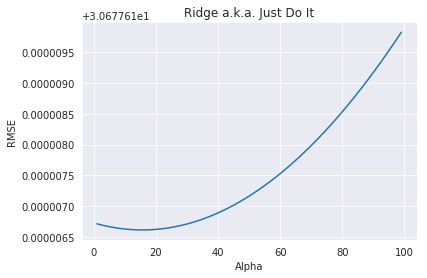

In [62]:
sns.set_style("darkgrid")
plt.plot(ridge_alphas, ridge_rmse_cv)
plt.title("Ridge a.k.a. Just Do It")
plt.xlabel("Alpha")
plt.ylabel("RMSE")
plt.show()

In [63]:
min_rmse_cv = np.min(ridge_rmse_cv)
bool_arr = np.array(ridge_rmse_cv) == min_rmse_cv
ridge_alphas[bool_arr]

array([16])

In [65]:
ridge = Ridge(alpha = 3, normalize=False, random_state=87)
def get_rmse(model):
    mse = cross_val_score(model, X_train, y_train, cv = 10, scoring = 'neg_mean_squared_error')
    return np.mean((-mse)**0.5)

get_rmse(ridge)

30.677616611567707

In [ ]:
# test_hire_stats

# Date變形
test_hire_stats["Date_year"] = test_hire_stats["Date"].apply(lambda x: x.split("-")[0]).apply(lambda x: int(x))
test_hire_stats["Date_month"] = test_hire_stats["Date"].apply(lambda x: x.split("-")[1]).apply(lambda x: int(x))
test_hire_stats["Date_day"] = test_hire_stats["Date"].apply(lambda x: x.split("-")[2]).apply(lambda x: int(x))

# week_of_day
test_hire_stats["week_of_day"] = test_hire_stats["Date"].apply(lambda x: int(datetime.datetime(int(x.split("-")[0]), int(x.split("-")[1]), int(x.split("-")[2])).weekday()))


# # week_of_day
# test_hire_stats["week_of_day"] = pd.Series()
# for i in range(0, len(test_hire_stats["Date"])):
#     test_hire_stats["week_of_day"][i] = int(datetime.datetime(test_hire_stats["Date_year"][i], test_hire_stats["Date_month"][i], test_hire_stats["Date_day"][i]).weekday())
    

test_hire_stats.head(5)




# import datetime
# datetime.datetime.today()
# datetime.datetime.today().weekday()
# datetime.datetime(2018, 11, 13).weekday()

In [ ]:
test_hire_stats.columns

In [ ]:
train_hire_stats.columns

In [ ]:
# model = Ridge(alpha = 49, normalize=False, random_state=87)

# desired_factors = ['Zone_ID', 'Hour_slot', 'week_of_day']

# train_data = train_hire_stats[desired_factors]
# target = train_hire_stats.Hire_count

# test_data = test_hire_stats[desired_factors]

# #fitting model with prediction data and telling it my target
# model.fit(train_data, target)

# model.predict(test_data.head())

In [ ]:
model = Ridge(alpha = 3, normalize=False, random_state=87)

desired_factors = ["Hour_slot", "Date_month", "week_of_day", "Zone_B", "Zone_G", "Zone_R", "Zone_W", "Zone_Y"]

train_data = train_hire_stats_4[desired_factors]
target = train_hire_stats_4.Hire_count

test_data = test_hire_stats_4[desired_factors]

#fitting model with prediction data and telling it my target
model.fit(train_data, target)

model.predict(test_data.head())

In [ ]:
model

In [ ]:
test_hire_stats["Hire_count"] = model.predict(test_data)
test_hire_stats["Hire_count"] = test_hire_stats["Hire_count"].apply(lambda x : round(x))
# test_hire_stats[["Test_ID", "Zone_ID", "Date", "Hour_slot", "Hire_count"]]
test_hire_stats

### python  date to integer stack overflow

> https://stackoverflow.com/questions/28154066/how-to-convert-datetime-to-integer-in-python

def to_integer(dt_time):

    return 10000*dt_time.year + 100*dt_time.month + dt_time.day   
    
---      
    
### python regression with categorical variables

> https://stackoverflow.com/questions/34007308/linear-regression-analysis-with-string-categorical-features-variables    
    
Linear regression analysis with string/categorical features (variables)?

Yes, you will have to convert everything to numbers. That requires thinking about what these attributes represent.

Usually there are three possibilities:

1. One-Hot encoding for categorical data
2. Arbitrary numbers for ordinal data
3. Use something like group means for categorical data (e. g. mean prices for city districts).

You have to be carefull to not infuse information you do not have in the application case.
    
---      
    
    
    
    
    

In [ ]:
from pandas_gbq import read_gbq


sql_statement = "SELECT * FROM test.people;"
chicago_bulls = read_gbq(sql_statement)
chicago_bulls

In [ ]:
# # 在某一個DB創一個新的table

# import csv

# import MySQLdb
# import pandas as pd
# import xlrd
# from datetime import datetime



# # cur.execute("CREATE DATABASE for_taxi DEFAULT CHARACTER SET 'utf8'")


# conn = MySQLdb.connect(host="127.0.0.1",    # your host, usually localhost
#                      user="root",         # your username
#                      passwd="",           # your password
#                      db = "for_taxi",    # name of the data base         
#                      use_unicode=True, 
#                      charset="utf8")


# cur = conn.cursor()

# # 如果数据表已经存在使用 execute() 方法删除表。
# cur.execute("DROP TABLE IF EXISTS zones")





# # create table & columns & datatype of each column
# sql = """CREATE TABLE zones (
#          Zone_ID INT,
#          Border_Left INT,
#          Border_Top INT,  
#          Border_Right INT,
#          Border_Bottom INT
#          );"""         
# cur.execute(sql)












# # for name, ddl in TABLES.items():
# #     try:
# #         print("Creating table {}: ".format(name), end='')
# #         cur.execute(ddl)
# #     except MySQLdb.connect.Error as err:
# #         if err.errno == errorcode.ER_TABLE_EXISTS_ERROR:
# #             print("already exists.")
# #         else:
# #             print(err.msg)
# #     else:
# #         print("OK")


# # train_gps_points_url = "/home/js/py_ds_nas/taxi_data/train_gps_points.csv"
# # train_hire_stats_url = "/home/js/py_ds_nas/taxi_data/train_hire_stats.csv"
# # zones_url = "/home/js/py_ds_nas/taxi_data/zones.csv"

# # test_hire_stats_url = "/home/js/py_ds_nas/taxi_data/test_hire_stats.csv"



# # with open("/home/js/py_ds_nas/taxi_data/train_gps_points.csv", newline="",  encoding="utf8") as csvfile:
# #     spamreader = csv.reader(csvfile)


# # for row in spamreader:
    
    
# csv_data = csv.reader("/home/js/py_ds_nas/taxi_data/zones.csv")
# for row in csv_data:
#     # Prepare SQL query to INSERT a record into the database.
# #     sql = """INSERT INTO movies(Zone_ID, Border_Left, Border_Top, Border_Right, Border_Bottom) 
# #                  VALUES ('%s', '%s', '%s', '%s', '%s');""" % (row[0], row[1], row[2], row[3], row[4])
 
#     query = """INSERT INTO zones(Zone_ID, Border_Left, Border_Top, Border_Right, Border_Bottom) 
#                  VALUES (%s, %s, %s, %s, %s);"""

#     values = 
# #     sql = """INSERT INTO zones(Zone_ID, Border_Left, Border_Top, Border_Right, Border_Bottom) 
# #                  VALUES ('%s', '%s', '%s', '%s', '%s');""" % (row[0], row[1], row[2], row[3], row[4])
    
#     print(sql)
#     try:
#        # Execute the SQL command
#        cur.execute(sql)
#        # Commit your changes in the database
#        conn.commit()
#     except:
#        # Rollback in case there is any error
#        conn.rollback()




# # conn.commit()    


# cur.close()
# conn.close()

In [ ]:
# 第一份資料 ： train_gps_points

import csv

import MySQLdb
import pandas as pd
import xlrd
from datetime import datetime



# cur.execute("CREATE DATABASE for_taxi DEFAULT CHARACTER SET 'utf8'")


conn = MySQLdb.connect(host="127.0.0.1",    # your host, usually localhost
                     user="root",         # your username
                     passwd="",           # your password
                     db = "for_taxi",    # name of the data base         
                     use_unicode=True, 
                     charset="utf8")


cur = conn.cursor()

# 如果数据表已经存在使用 execute() 方法删除表。
cur.execute("DROP TABLE IF EXISTS train_gps_points")



# Datetime 	Longitude_X 	Latitude_Y 	Zone_ID

# create table & columns & datatype of each column
sql = """CREATE TABLE train_gps_points (
         train_Datetime VARCHAR(50),
         Longitude_X FLOAT,
         Latitude_Y FLOAT,  
         Zone_ID INT
         );"""         
cur.execute(sql)





# train_gps_points_url = "/home/js/py_ds_nas/taxi_data/train_gps_points.csv"


with open("/home/js/py_ds_nas/taxi_data/train_gps_points.csv", newline='',  encoding="utf8") as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None) # 避免headers被匯進來
    
    for row in reader:
        # Prepare SQL query to INSERT a record into the database.
        sql = """insert into train_gps_points(train_Datetime, train_Longitude_X, train_Latitude_Y, Zone_ID) 
                     VALUES (%s, %s, %s, %s)""" % (row[0], row[1], row[2], row[3])
        print(sql)
        
        try:
            # Execute the SQL command
            cur.execute(sql)
            # Commit your changes in the database
            conn.commit()
            
            print("OK")
        except:
            # Rollback in case there is any error
            conn.rollback()
            
            print("NOOOOOOOOOOO")



conn.commit()    


cur.close()
conn.close()




# 這次是運氣好，剛好我要的是int，可是表頭是文字，所以匯失敗之後，看起來剛好是對的
# 那要怎麼才會不要匯入第一列的表頭呢？ 在readers後面加入 next(reader, None) # 避免headers被匯進來

In [ ]:
# 第二份資料 ： train_hire_stats


# 在某一個DB創一個新的table

import csv

import MySQLdb
import pandas as pd
import xlrd
from datetime import datetime



# cur.execute("CREATE DATABASE for_taxi DEFAULT CHARACTER SET 'utf8'")


conn = MySQLdb.connect(host="127.0.0.1",    # your host, usually localhost
                     user="root",         # your username
                     passwd="",           # your password
                     db = "for_taxi",    # name of the data base         
                     use_unicode=True, 
                     charset="utf8")


cur = conn.cursor()

# 如果数据表已经存在使用 execute() 方法删除表。
cur.execute("DROP TABLE IF EXISTS train_hire_stats")




# Zone_ID 	Date 	Hour_slot 	Hire_count

# create table & columns & datatype of each column --------------- 關於日期部份，不能有"-" : 2017-01-01 -> 20170101
sql = """CREATE TABLE train_hire_stats (
         Zone_ID INT,
         train_Date DATE NOT NULL,    
         Hour_slot INT,  
         Hire_count INT
         );"""         
cur.execute(sql)





# train_gps_points_url = "/home/js/py_ds_nas/taxi_data/train_gps_points.csv"
# train_hire_stats_url = "/home/js/py_ds_nas/taxi_data/train_hire_stats.csv"
# zones_url = "/home/js/py_ds_nas/taxi_data/zones.csv"
# test_hire_stats_url = "/home/js/py_ds_nas/taxi_data/test_hire_stats.csv"

with open("/home/js/py_ds_nas/taxi_data/data/train_hire_stats-2.csv", newline='',  encoding="utf8") as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None) # 避免headers被匯進來
    
    for row in reader:
        # Prepare SQL query to INSERT a record into the database.
        sql = """insert into train_hire_stats(Zone_ID, train_Date, Hour_slot, Hire_count) 
                     VALUES (%s, %s, %s, %s)""" % (row[0], row[1], row[2], row[3])
        print(sql)
        
        try:
            # Execute the SQL command
            cur.execute(sql)
            # Commit your changes in the database
            conn.commit()
            
            print("OK")
        except:
            # Rollback in case there is any error
            conn.rollback()
            
            print("NOOOOOOOOOOO")



conn.commit()    


cur.close()
conn.close()




# 這次是運氣好，剛好我要的是int，可是表頭是文字，所以匯失敗之後，看起來剛好是對的
# 那要怎麼才會不要匯入第一列的表頭呢？ 在readers後面加入 next(reader, None) # 避免headers被匯進來

In [1]:
# # 第二份資料 ： train_hire_stats


# # 在某一個DB創一個新的table

# import csv

# import MySQLdb
# import pandas as pd
# import xlrd
# from datetime import datetime



# # cur.execute("CREATE DATABASE for_taxi DEFAULT CHARACTER SET 'utf8'")


# conn = MySQLdb.connect(host="127.0.0.1",    # your host, usually localhost
#                      user="root",         # your username
#                      passwd="",           # your password
#                      db = "for_taxi",    # name of the data base         
#                      use_unicode=True, 
#                      charset="utf8")


# cur = conn.cursor()

# # 如果数据表已经存在使用 execute() 方法删除表。
# cur.execute("DROP TABLE IF EXISTS train_hire_stats______test")



# # # Zone_ID 	Date 	Hour_slot 	Hire_count

# # create table & columns & datatype of each column --------------- 關於日期部份，不能有"-" : 2017-01-01 -> 20170101
# sql = """CREATE TABLE train_hire_stats______test (
#          Zone_ID INT,
#          train_Date DATE NOT NULL,    
#          Hour_slot INT,  
#          Hire_count INT
#          );"""         
# cur.execute(sql)





# # train_gps_points_url = "/home/js/py_ds_nas/taxi_data/train_gps_points.csv"
# # train_hire_stats_url = "/home/js/py_ds_nas/taxi_data/train_hire_stats.csv"
# # zones_url = "/home/js/py_ds_nas/taxi_data/zones.csv"
# # test_hire_stats_url = "/home/js/py_ds_nas/taxi_data/test_hire_stats.csv"


# sql = """LOAD DATA LOCAL INFILE '/home/js/py_ds_nas/taxi_data/data/train_hire_stats-2.csv' IGNORE 
# INTO TABLE train_hire_stats______test
# FIELDS TERMINATED BY ',' 
# LINES TERMINATED BY '\n'
# IGNORE 1 LINES"""


# # ('Zone_ID', 'train_Date', 'Hour_slot', 'Hire_count' )



# try:
#     # Execute the SQL command
#     cur.execute(sql)
#     # Commit your changes in the database
#     conn.commit()

#     print("OK")
# except:
#     # Rollback in case there is any error
#     conn.rollback()

#     print("NOOOOOOOOOOO")



# conn.commit()    


# cur.close()
# conn.close()




OK


/home/js/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: Warning: (1051, "Unknown table 'for_taxi.train_hire_stats______test'")


In [ ]:
1+2

In [ ]:
# 第三份資料 ： zones

import csv

import MySQLdb
import pandas as pd
import xlrd
from datetime import datetime



# cur.execute("CREATE DATABASE for_taxi DEFAULT CHARACTER SET 'utf8'")


conn = MySQLdb.connect(host="127.0.0.1",    # your host, usually localhost
                     user="root",         # your username
                     passwd="",           # your password
                     db = "for_taxi",    # name of the data base         
                     use_unicode=True, 
                     charset="utf8")


cur = conn.cursor()

# 如果数据表已经存在使用 execute() 方法删除表。
cur.execute("DROP TABLE IF EXISTS zones")





# create table & columns & datatype of each column
sql = """CREATE TABLE zones (
         Zone_ID INT,
         Border_Left INT,
         Border_Top INT,  
         Border_Right INT,
         Border_Bottom INT
         );"""         
cur.execute(sql)





# train_gps_points_url = "/home/js/py_ds_nas/taxi_data/train_gps_points.csv"
# train_hire_stats_url = "/home/js/py_ds_nas/taxi_data/train_hire_stats.csv"
# zones_url = "/home/js/py_ds_nas/taxi_data/zones.csv"
# test_hire_stats_url = "/home/js/py_ds_nas/taxi_data/test_hire_stats.csv"

with open("/home/js/py_ds_nas/taxi_data/zones.csv", newline='',  encoding="utf8") as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None) # 避免headers被匯進來
    
    for row in reader:
        # Prepare SQL query to INSERT a record into the database.
        sql = """insert into zones(Zone_ID, Border_Left, Border_Top, Border_Right, Border_Bottom) 
                     VALUES (%s, %s, %s, %s, %s)""" % (row[0], row[1], row[2], row[3], row[4])
        print(sql)
        
        try:
            # Execute the SQL command
            cur.execute(sql)
            # Commit your changes in the database
            conn.commit()
            
            print("OK")
        except:
            # Rollback in case there is any error
            conn.rollback()
            
            print("NOOOOOOOOOOO")



conn.commit()    


cur.close()
conn.close()




# 這次是運氣好，剛好我要的是int，可是表頭是文字，所以匯失敗之後，看起來剛好是對的
# 那要怎麼才會不要匯入第一列的表頭呢？ 在readers後面加入 next(reader, None) # 避免headers被匯進來

In [ ]:
# 第四份資料 ： test_hire_stats

import csv

import MySQLdb
import pandas as pd
import xlrd
from datetime import datetime



# cur.execute("CREATE DATABASE for_taxi DEFAULT CHARACTER SET 'utf8'")


conn = MySQLdb.connect(host="127.0.0.1",    # your host, usually localhost
                     user="root",         # your username
                     passwd="",           # your password
                     db = "for_taxi",    # name of the data base         
                     use_unicode=True, 
                     charset="utf8")


cur = conn.cursor()

# 如果数据表已经存在使用 execute() 方法删除表。
cur.execute("DROP TABLE IF EXISTS zones")





# create table & columns & datatype of each column
sql = """CREATE TABLE zones (
         Zone_ID INT,
         Border_Left INT,
         Border_Top INT,  
         Border_Right INT,
         Border_Bottom INT
         );"""         
cur.execute(sql)





# train_gps_points_url = "/home/js/py_ds_nas/taxi_data/train_gps_points.csv"
# train_hire_stats_url = "/home/js/py_ds_nas/taxi_data/train_hire_stats.csv"
# zones_url = "/home/js/py_ds_nas/taxi_data/zones.csv"
# test_hire_stats_url = "/home/js/py_ds_nas/taxi_data/test_hire_stats.csv"

with open("/home/js/py_ds_nas/taxi_data/zones.csv", newline='',  encoding="utf8") as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None) # 避免headers被匯進來
    
    for row in reader:
        # Prepare SQL query to INSERT a record into the database.
        sql = """insert into zones(Zone_ID, Border_Left, Border_Top, Border_Right, Border_Bottom) 
                     VALUES (%s, %s, %s, %s, %s)""" % (row[0], row[1], row[2], row[3], row[4])
        print(sql)
        
        try:
            # Execute the SQL command
            cur.execute(sql)
            # Commit your changes in the database
            conn.commit()
            
            print("OK")
        except:
            # Rollback in case there is any error
            conn.rollback()
            
            print("NOOOOOOOOOOO")



conn.commit()    


cur.close()
conn.close()




# 這次是運氣好，剛好我要的是int，可是表頭是文字，所以匯失敗之後，看起來剛好是對的
# 那要怎麼才會不要匯入第一列的表頭呢？ 在readers後面加入 next(reader, None) # 避免headers被匯進來

In [ ]:
#!/usr/bin/env python # -*- coding:utf-8 -*- 
import uuid 
import time 

class Student(): 
    def __init__(self, stuid): 
        self.stuid = stuid 

class Class(): 
    def __init__(self, classid): 
        self.classid = classid 
        self.student = Student(uuid.uuid1()) 
        
if __name__ == '__main__': 
    li = [] 
    for i in range(500): 
            li.append(Class(uuid.uuid1())) 
    print('create instance') 
    time.sleep(5) 
    li[:] = [] 
    print('release instance') 
    while True: 
        time.sleep(10) 
            
# 原文網址：https://itw01.com/GYUCAED.html